In [38]:
import pandas as pd
import numpy as np  


In [39]:
num_samples = 10

random_state = 16

num_of_ratios = 5

## The metadata file
Load the metadata file. We index it by sample_id, but keep this column as well as a feature

In [40]:
metadata = pd.read_csv("../Data/metadata.csv").set_index('sample_id',drop = False)

metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1494 entries, S0000 to S1505
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   sample_id          1494 non-null   object
 1   split              1494 non-null   object
 2   instrument_type    1494 non-null   object
 3   features_path      1494 non-null   object
 4   features_md5_hash  1494 non-null   object
dtypes: object(5)
memory usage: 70.0+ KB


In [41]:
metadata.head()

sample_id  split instrument_type             features_path  \
sample_id                                                              
S0000         S0000  train      commercial  train_features/S0000.csv   
S0001         S0001  train      commercial  train_features/S0001.csv   
S0002         S0002  train      commercial  train_features/S0002.csv   
S0003         S0003  train      commercial  train_features/S0003.csv   
S0004         S0004  train      commercial  train_features/S0004.csv   

                          features_md5_hash  
sample_id                                    
S0000      017b9a71a702e81a828e6242aa15f049  
S0001      0d09840214054d254bd49436c6a6f315  
S0002      3f58b3c9b001bfed6ed4e4f757083e09  
S0003      e9a12f96114a2fda60b36f4c0f513fb1  
S0004      b67603d3931897bfa796ac42cc16de78

We complete the paths in the "features_path" column so that we can read the corresponding csv files more easily.

In [42]:
def replace_value (x):
    return x.replace(" ","")

new_path = "../Data/"

def fix_path(incomplete_path):
    return new_path + incomplete_path

metadata.features_path = metadata['features_path'].apply(replace_value)
metadata.features_path = metadata['features_path'].apply(fix_path)

metadata.head()

sample_id  split instrument_type                     features_path  \
sample_id                                                                      
S0000         S0000  train      commercial  ../Data/train_features/S0000.csv   
S0001         S0001  train      commercial  ../Data/train_features/S0001.csv   
S0002         S0002  train      commercial  ../Data/train_features/S0002.csv   
S0003         S0003  train      commercial  ../Data/train_features/S0003.csv   
S0004         S0004  train      commercial  ../Data/train_features/S0004.csv   

                          features_md5_hash  
sample_id                                    
S0000      017b9a71a702e81a828e6242aa15f049  
S0001      0d09840214054d254bd49436c6a6f315  
S0002      3f58b3c9b001bfed6ed4e4f757083e09  
S0003      e9a12f96114a2fda60b36f4c0f513fb1  
S0004      b67603d3931897bfa796ac42cc16de78

According to the competition description, some measurements are taken with commercial and some with SAM, which is an instrument suite on the Curiosity rover on Mars. Here we will check what proportion of samples in the metadata file are associated with commercial vs SAM instruments

In [43]:
metadata.instrument_type.value_counts(normalize=True)

instrument_type
commercial    1.0
Name: proportion, dtype: float64

Turns out they are all commercial. Now store the various paths to csv folders into dictionaries, depending on whether the samples are in the train, val or test set. We do not have access to any test_files, so those can probably be disregarded. After this point, metadata will not be used again


In [44]:
# creates a dictionary that contains a path for each sample
train_files = metadata[metadata.split == "train"]["features_path"].to_dict()
val_files = metadata[metadata.split == 'val']["features_path"].to_dict()
test_files = metadata[metadata.split == 'test']["features_path"].to_dict()

## The labels 

In [45]:
train_labels = pd.read_csv("../Data/train_labels.csv",index_col="sample_id")

train_labels.head()

basalt  carbonate  chloride  iron_oxide  oxalate  oxychlorine  \
sample_id                                                                  
S0000           0          0         0           0        0            0   
S0001           0          1         0           0        0            0   
S0002           0          0         0           0        0            1   
S0003           0          1         0           1        0            0   
S0004           0          0         0           1        0            1   

           phyllosilicate  silicate  sulfate  sulfide  
sample_id                                              
S0000                   0         0        1        0  
S0001                   0         0        0        0  
S0002                   0         0        0        0  
S0003                   0         0        1        0  
S0004                   1         0        0        0

We can see what proportion of the labels contains each ion

In [46]:
for column_name in train_labels.columns:
    print(train_labels[column_name].value_counts(normalize=True))

basalt
0    0.87931
1    0.12069
Name: proportion, dtype: float64
carbonate
0    0.871353
1    0.128647
Name: proportion, dtype: float64
chloride
0    0.876658
1    0.123342
Name: proportion, dtype: float64
iron_oxide
0    0.775862
1    0.224138
Name: proportion, dtype: float64
oxalate
0    0.960212
1    0.039788
Name: proportion, dtype: float64
oxychlorine
0    0.762599
1    0.237401
Name: proportion, dtype: float64
phyllosilicate
0    0.679045
1    0.320955
Name: proportion, dtype: float64
silicate
0    0.862069
1    0.137931
Name: proportion, dtype: float64
sulfate
0    0.803714
1    0.196286
Name: proportion, dtype: float64
sulfide
0    0.952255
1    0.047745
Name: proportion, dtype: float64


Print the ions in descending order of frequency:

In [47]:
sums_normalized = train_labels.aggregate("sum").sort_values(ascending = False)

print(sums_normalized.index.values)

['phyllosilicate' 'oxychlorine' 'iron_oxide' 'sulfate' 'silicate'
 'carbonate' 'chloride' 'basalt' 'sulfide' 'oxalate']


Now put them in a bar plot

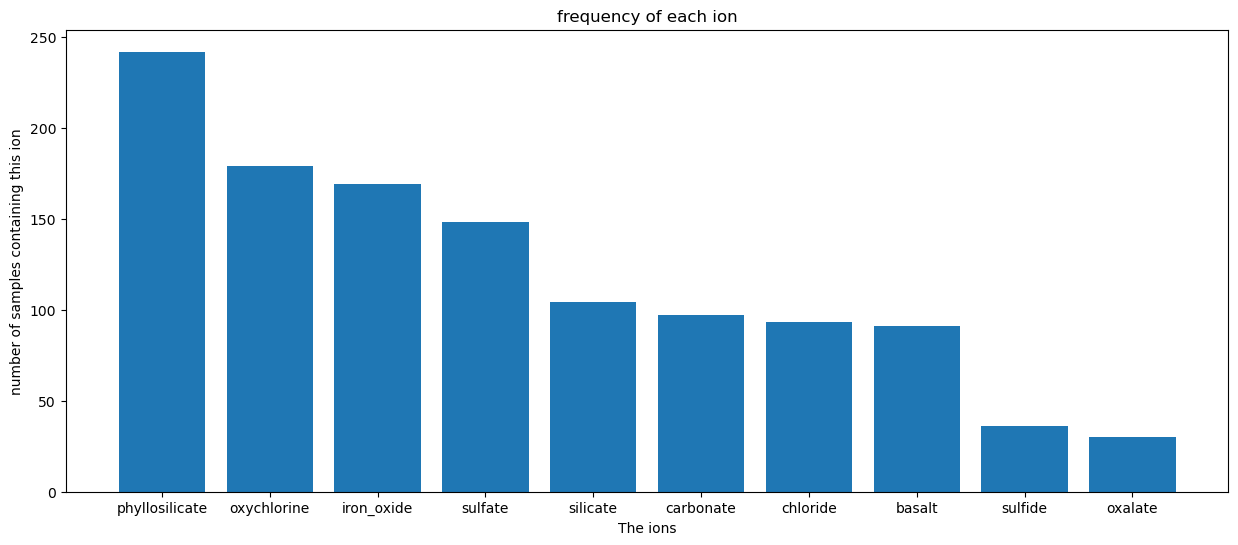

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

plt.bar( sums_normalized.index.values, sums_normalized.values)

plt.title('frequency of each ion')

plt.xlabel("The ions")

plt.ylabel("number of samples containing this ion")

plt.show()



## The Samples
Here we explore the information contained in files corresponding to individual samples.

For a collection of samples we plot temperature as a function of time.

In [52]:
from random import sample 

nrows = 4
ncols = 4

# creates a list of samples with nrows*ncols elements

samples_list = sample(list(train_files.keys()),nrows*ncols)



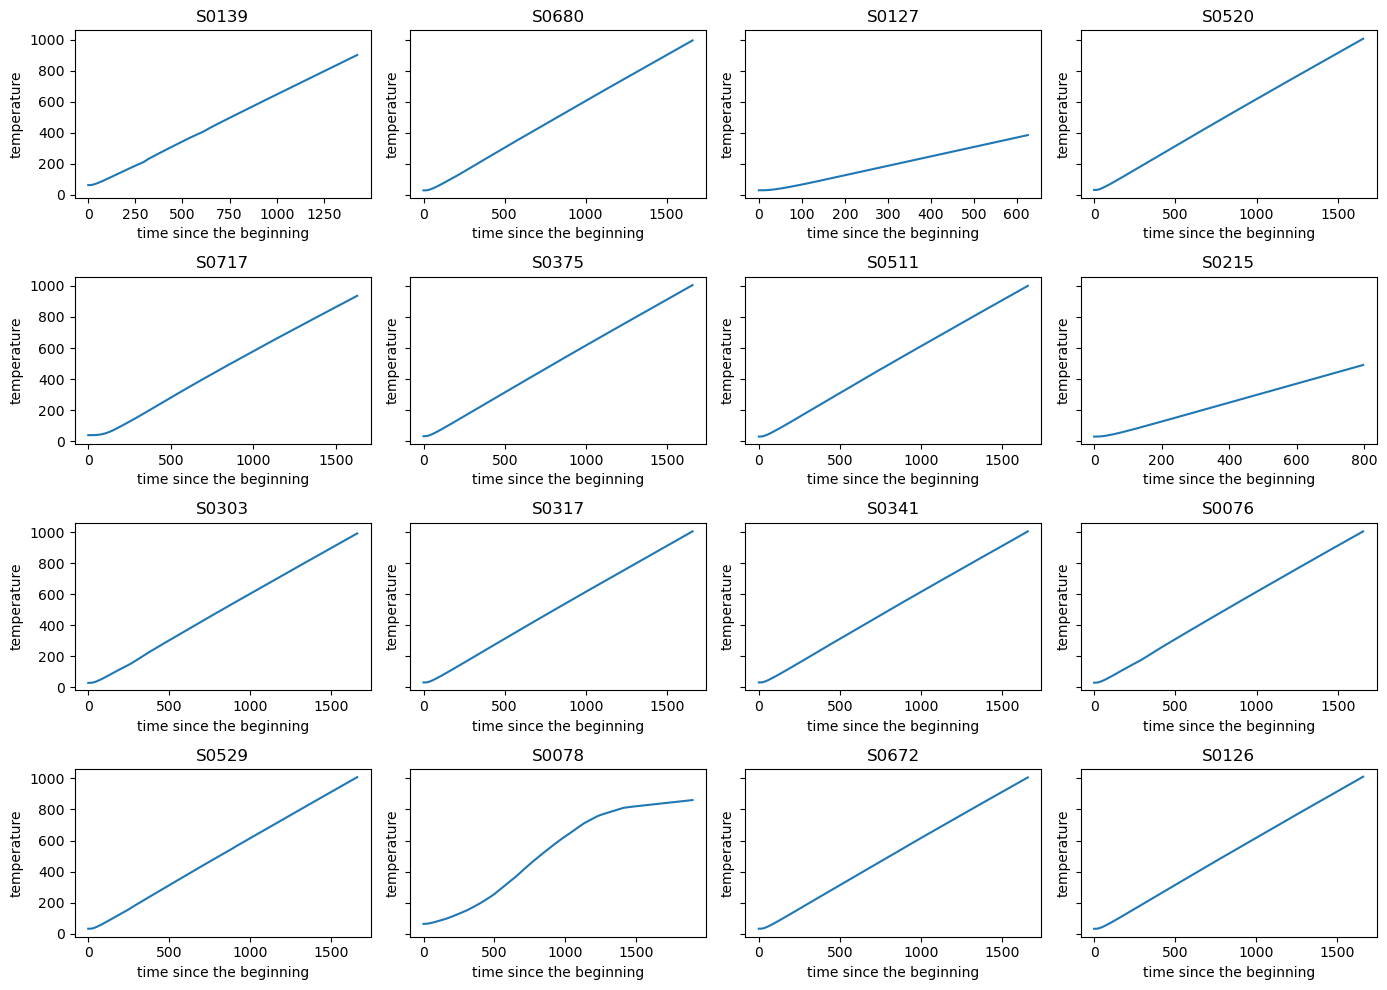

In [63]:
# Create a figure and an array of subplots indexed using axis

fig, ax = plt.subplots(nrows = nrows,ncols = ncols,sharey = True,figsize = (10*nrows,10*ncols))


for i, sample in enumerate(samples_list): 

    plt.subplot(nrows,ncols,i+1)

    df = pd.read_csv(train_files[sample])

    plt.plot(df.time,df.temp)
       
    plt.xlabel('time since the beginning')
    
    plt.ylabel('temperature')
    
    plt.title(sample)



fig.set_size_inches(14,10)



fig.tight_layout()

plt.show()



We notice that the temperature is increasing with time in the samples above

## Abundance grouped by m/z

Now we plot the various ions grouped by m/z, on a logarithmic scale.

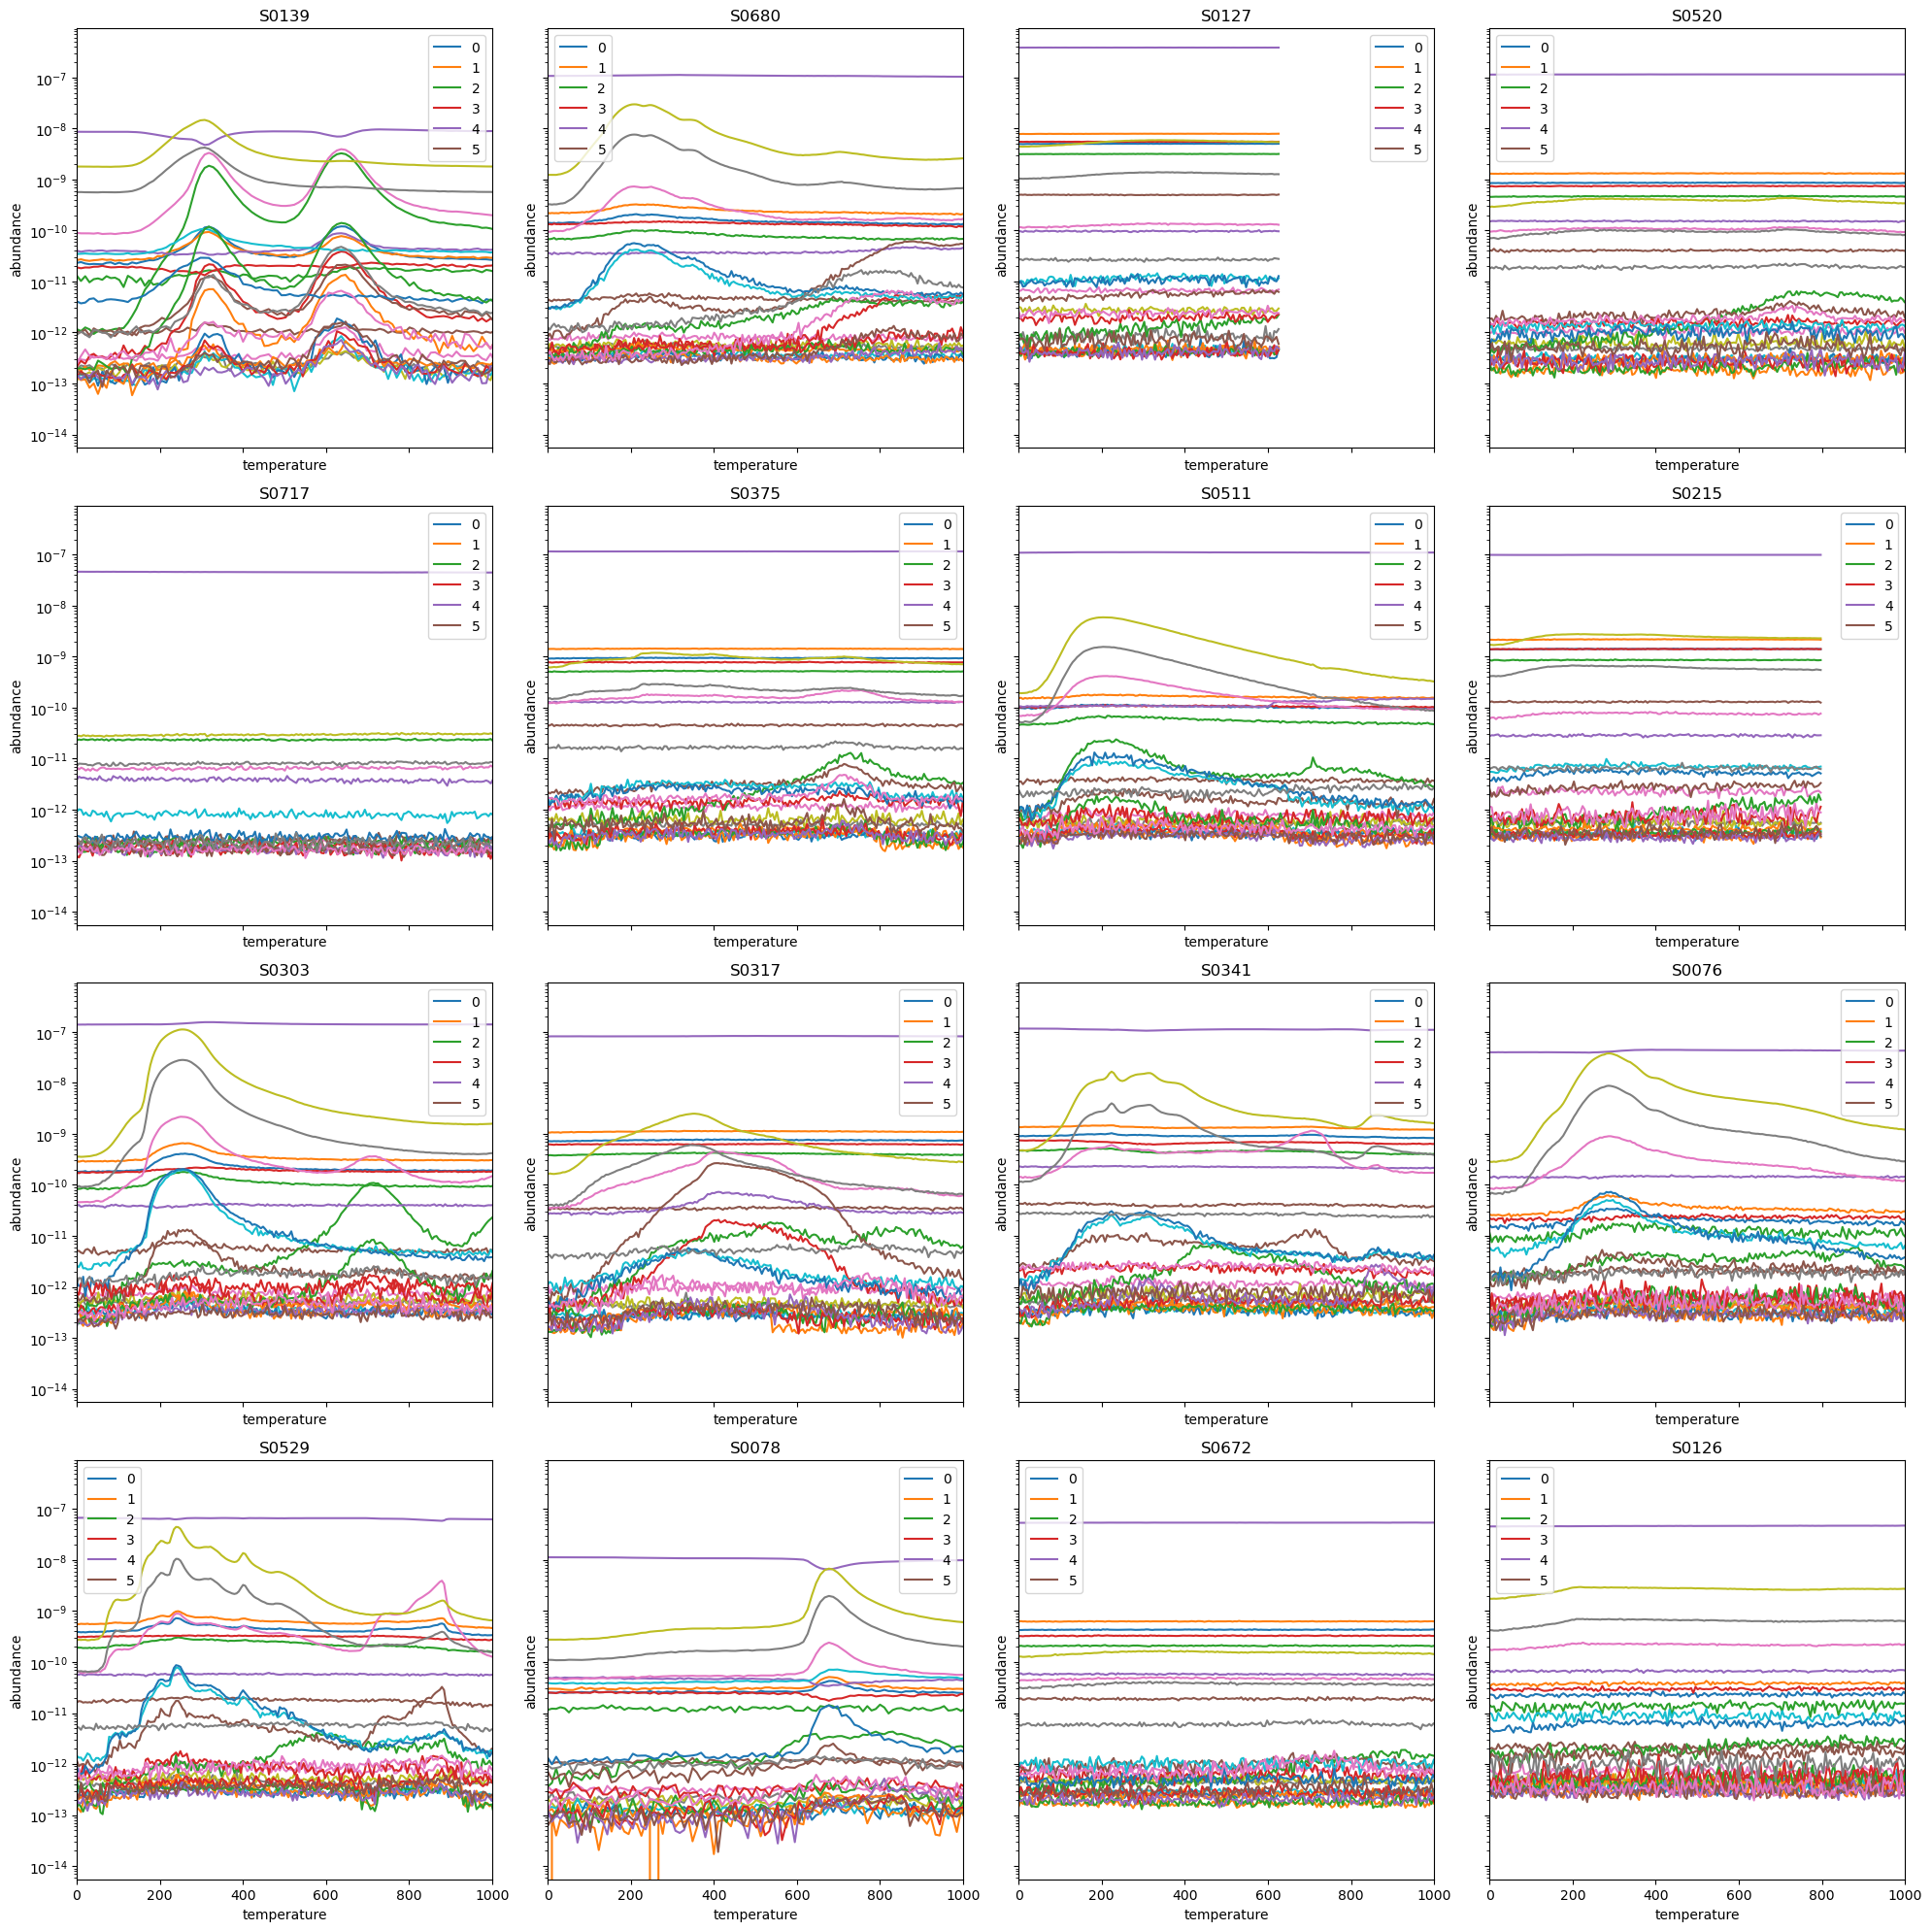

In [65]:
nrows = 4
ncols = 4
num_samples = nrows*ncols

fig, ax = plt.subplots(nrows,ncols,sharex = True,sharey = True,figsize = (5* nrows,5* ncols))


for i, sample in enumerate(samples_list):

    df = pd.read_csv(train_files[sample])
    

    plt.subplot(nrows,ncols,i+1)

    

    for mz in range(0,28):
        X = df[df['m/z'] == mz].time
        y = df[df['m/z'] == mz].abundance

        # We show a legend only for the first few values of mz in order to not clutter the picture
             
        if mz<=5:
            plt.plot(X,y,label = str(mz))
        else:
            plt.plot(X,y,label = "")
       

        plt.xlabel('temperature')
        plt.ylabel('abundance')
        plt.xlim(0,1000)
        
        # ax[i] = plt.show()
    
    plt.legend()


    
    plt.yscale('log')
    plt.title(sample)
    
    del df


fig.tight_layout()     
    
fig.show()






## Preprocessing the data

We do the data cleaning suggested by the post. Note that the part about removing non-integer values of m/z is probably not relevant to us, it seems that it only applies to SAM samples, which we do not have access to.

In [15]:
def drop_non_int_and_He(df):
    df2 = df
    df2 = df2[df2['m/z'].transform(round) == df2['m/z']]
    df2 = df2[df2['m/z']<100]
    df2 = df2[df2['m/z'] != 4]
    return df2

In [16]:
def subtract_min(df):    

    df["abundance_minsub"] = df.groupby(["m/z"])["abundance"].transform(
        lambda x: (x - x.min())
    )

    return df


The next function scales the abundances by the formula $\frac{x-x_{\mathrm{min}}}{x_{max}-x_{min}}$ and forces them to be in the range (0,1)

In [17]:
from sklearn.preprocessing import minmax_scale

def scale_to_zero_one(df):
    df['zero_one_rescale'] = minmax_scale(df['abundance_minsub'])
    assert (df['zero_one_rescale'].max()<=1)
    return df
    


The following combines the procedures above

In [18]:
def preprocess(df):
    return scale_to_zero_one(subtract_min(drop_non_int_and_He(df)))

/var/folders/sb/bm5l_dgs6vg61tdy4phf0vcm0000gn/T/ipykernel_13664/3252275473.py:78: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


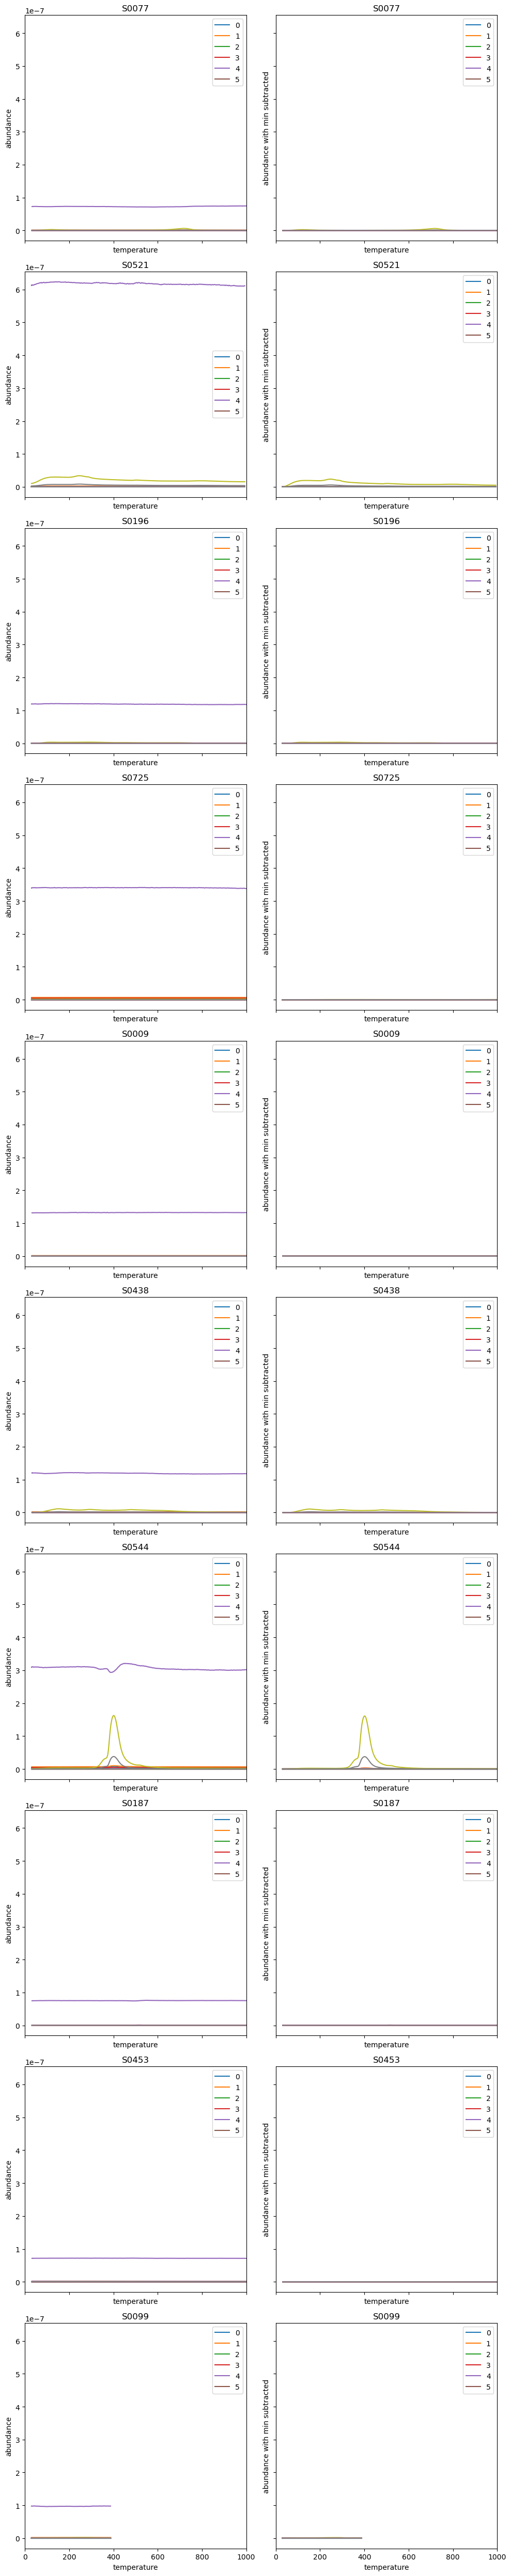

In [19]:

# samples_list = ['S0001','S0025']
# num_samples = len(samples_list)

fig, ax = plt.subplots(num_samples,2,sharex = True,sharey = True,figsize = (10,5*num_samples))


for i, sample in enumerate(samples_list):



    df = pd.read_csv(train_files[sample])

    df_mod = subtract_min(drop_non_int_and_He(df))



    plt.subplot(num_samples,2,2*i+1)

    

    for mz in range(0,28):
        X = df[df['m/z'] == mz].temp
        y = df[df['m/z'] == mz].abundance

        # We show a legend only for the first few values of mz in order to not clutter the picture
             
        if mz<=5:
            plt.plot(X,y,label = str(mz))
        else:
            plt.plot(X,y,label = "")       
        

        plt.xlabel('temperature')
        plt.ylabel('abundance')
        plt.xlim(0,1000)
        plt.title(sample)

        plt.legend()

        plt.title(sample)
        
        # ax[i] = plt.show()
        plt.yscale('linear')
    
    plt.subplot(num_samples,2,2*i+2)    

    for mz in range(0,28):
        X = df_mod[df_mod['m/z'] == mz].temp
        y = df_mod[df_mod['m/z'] == mz].abundance_minsub

        # We show a legend only for the first few values of mz in order to not clutter the picture
             
        if mz<=5:
            plt.plot(X,y,label = str(mz))
        else:
            plt.plot(X,y,label = "")       
        

        plt.xlabel('temperature')
        plt.ylabel('abundance with min subtracted')
        plt.xlim(0,1000)
        plt.title(sample)
        
        # ax[i] = plt.show()
    
        plt.legend()


    
        plt.yscale('linear')
    
    



fig.tight_layout()     
    
fig.show()





Now we plot our samples with the 0-1 rescaling included

/var/folders/sb/bm5l_dgs6vg61tdy4phf0vcm0000gn/T/ipykernel_13664/1047895987.py:78: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


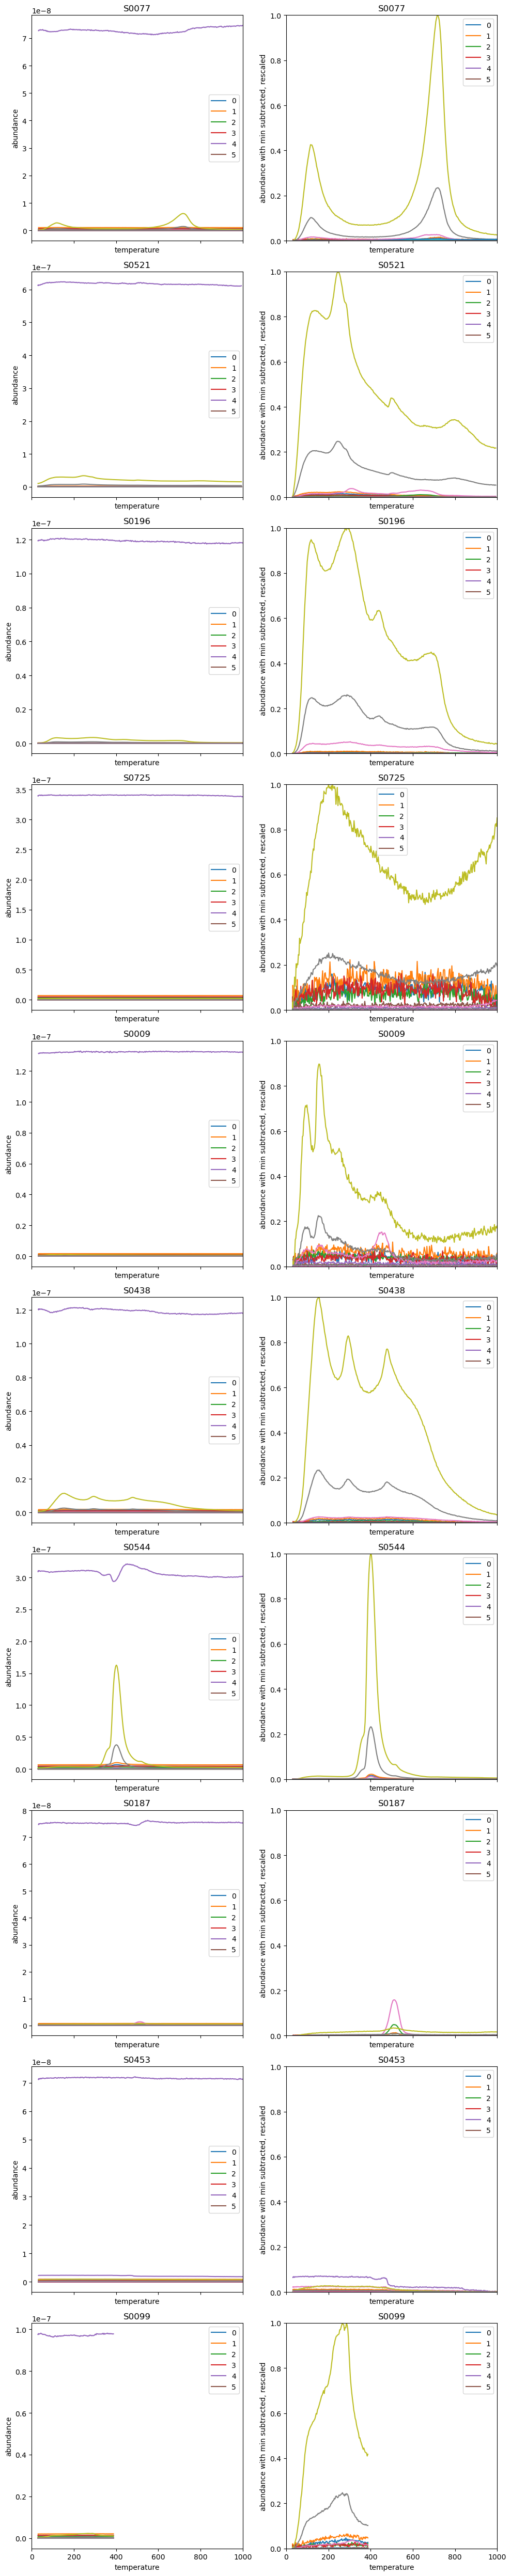

In [20]:


fig, ax = plt.subplots(num_samples,2,sharex = True,figsize = (10,5*num_samples))




for i, sample in enumerate(samples_list):



    df = pd.read_csv(train_files[sample])

    df_mod = preprocess(df)



    plt.subplot(num_samples,2,2*i+1)

    

    for mz in range(0,28):
        X = df[df['m/z'] == mz].temp
        y = df[df['m/z'] == mz].abundance

        # We show a legend only for the first few values of mz in order to not clutter the picture
             
        if mz<=5:
            plt.plot(X,y,label = str(mz))
        else:
            plt.plot(X,y,label = "")       
        

        plt.xlabel('temperature')
        plt.ylabel('abundance')
        plt.xlim(0,1000)
        plt.title(sample)

        plt.legend()

        plt.title(sample)
        
        # ax[i] = plt.show()
        plt.yscale('linear')
    
    plt.subplot(num_samples,2,2*i+2)    

    for mz in range(0,28):
        X = df_mod[df_mod['m/z'] == mz].temp
        y = df_mod[df_mod['m/z'] == mz].zero_one_rescale

        # We show a legend only for the first few values of mz in order to not clutter the picture
             
        if mz<=5:
            plt.plot(X,y,label = str(mz))
        else:
            plt.plot(X,y,label = "")       
        

        plt.xlabel('temperature')
        plt.ylabel('abundance with min subtracted, rescaled')
        plt.xlim(0,1000)
        plt.ylim(0,1)
        plt.title(sample)
        
        # ax[i] = plt.show()
    
        plt.legend()


    
        plt.yscale('linear')
    
    



fig.tight_layout()     
    
fig.show()





Now we will write a function that picks out the most prominent lines

In [21]:
# The following takes in a dataframe with a zero_one_rescale column and returns a list 

def find_relevant_ratios(df):

    # The following variable stores all existing ratios in a list, after removing duplicates

    existing_ratios = list(set(df["m/z"].values))

    
    

    # the fist column will store the value of m/z, the second the corresponding mean and the third the std_dev. The fourth is the sum.

    comp_table = np.zeros((len(existing_ratios),4)) 

    for i,ratio_value in enumerate(existing_ratios):
        
        comp_table[i,0] = ratio_value 
        
        df_temp = df.loc[df["m/z"]==ratio_value] # look at the subset of the dataframe corresponding to the ratio
        
        comp_table[i,1] = np.nanmean(df_temp.zero_one_rescale.values)
        comp_table[i,2] = np.nanstd(df_temp.zero_one_rescale.values)
        comp_table[i,3] = comp_table[i,1]+comp_table[i,2]
        
        del df_temp
    
    # now we sort the table with respect to highest sum of mean and standard deviation
    
    comp_table[comp_table[:,3].argsort()[::-1]]

    # we return the num_of_ratios most relevant values of m/z

    return comp_table[comp_table[:,3].argsort()[::-1]][:num_of_ratios,0]



Check that it works:

In [22]:

df = pd.read_csv(train_files['S0025'])

df_mod = preprocess(df)

print(find_relevant_ratios(df_mod))

[28. 44. 32. 16. 18.]


The following puts together what we have done. It first creates a standardized column, then it selects the most relevant features and gets rid of the rest. It returns a new data frame containing only the most relevant values of m/z

Now create plots to see what's going on

In [23]:
from random import sample

samples_list = sample(list(train_files.keys()),5)

num_samples = len(samples_list)

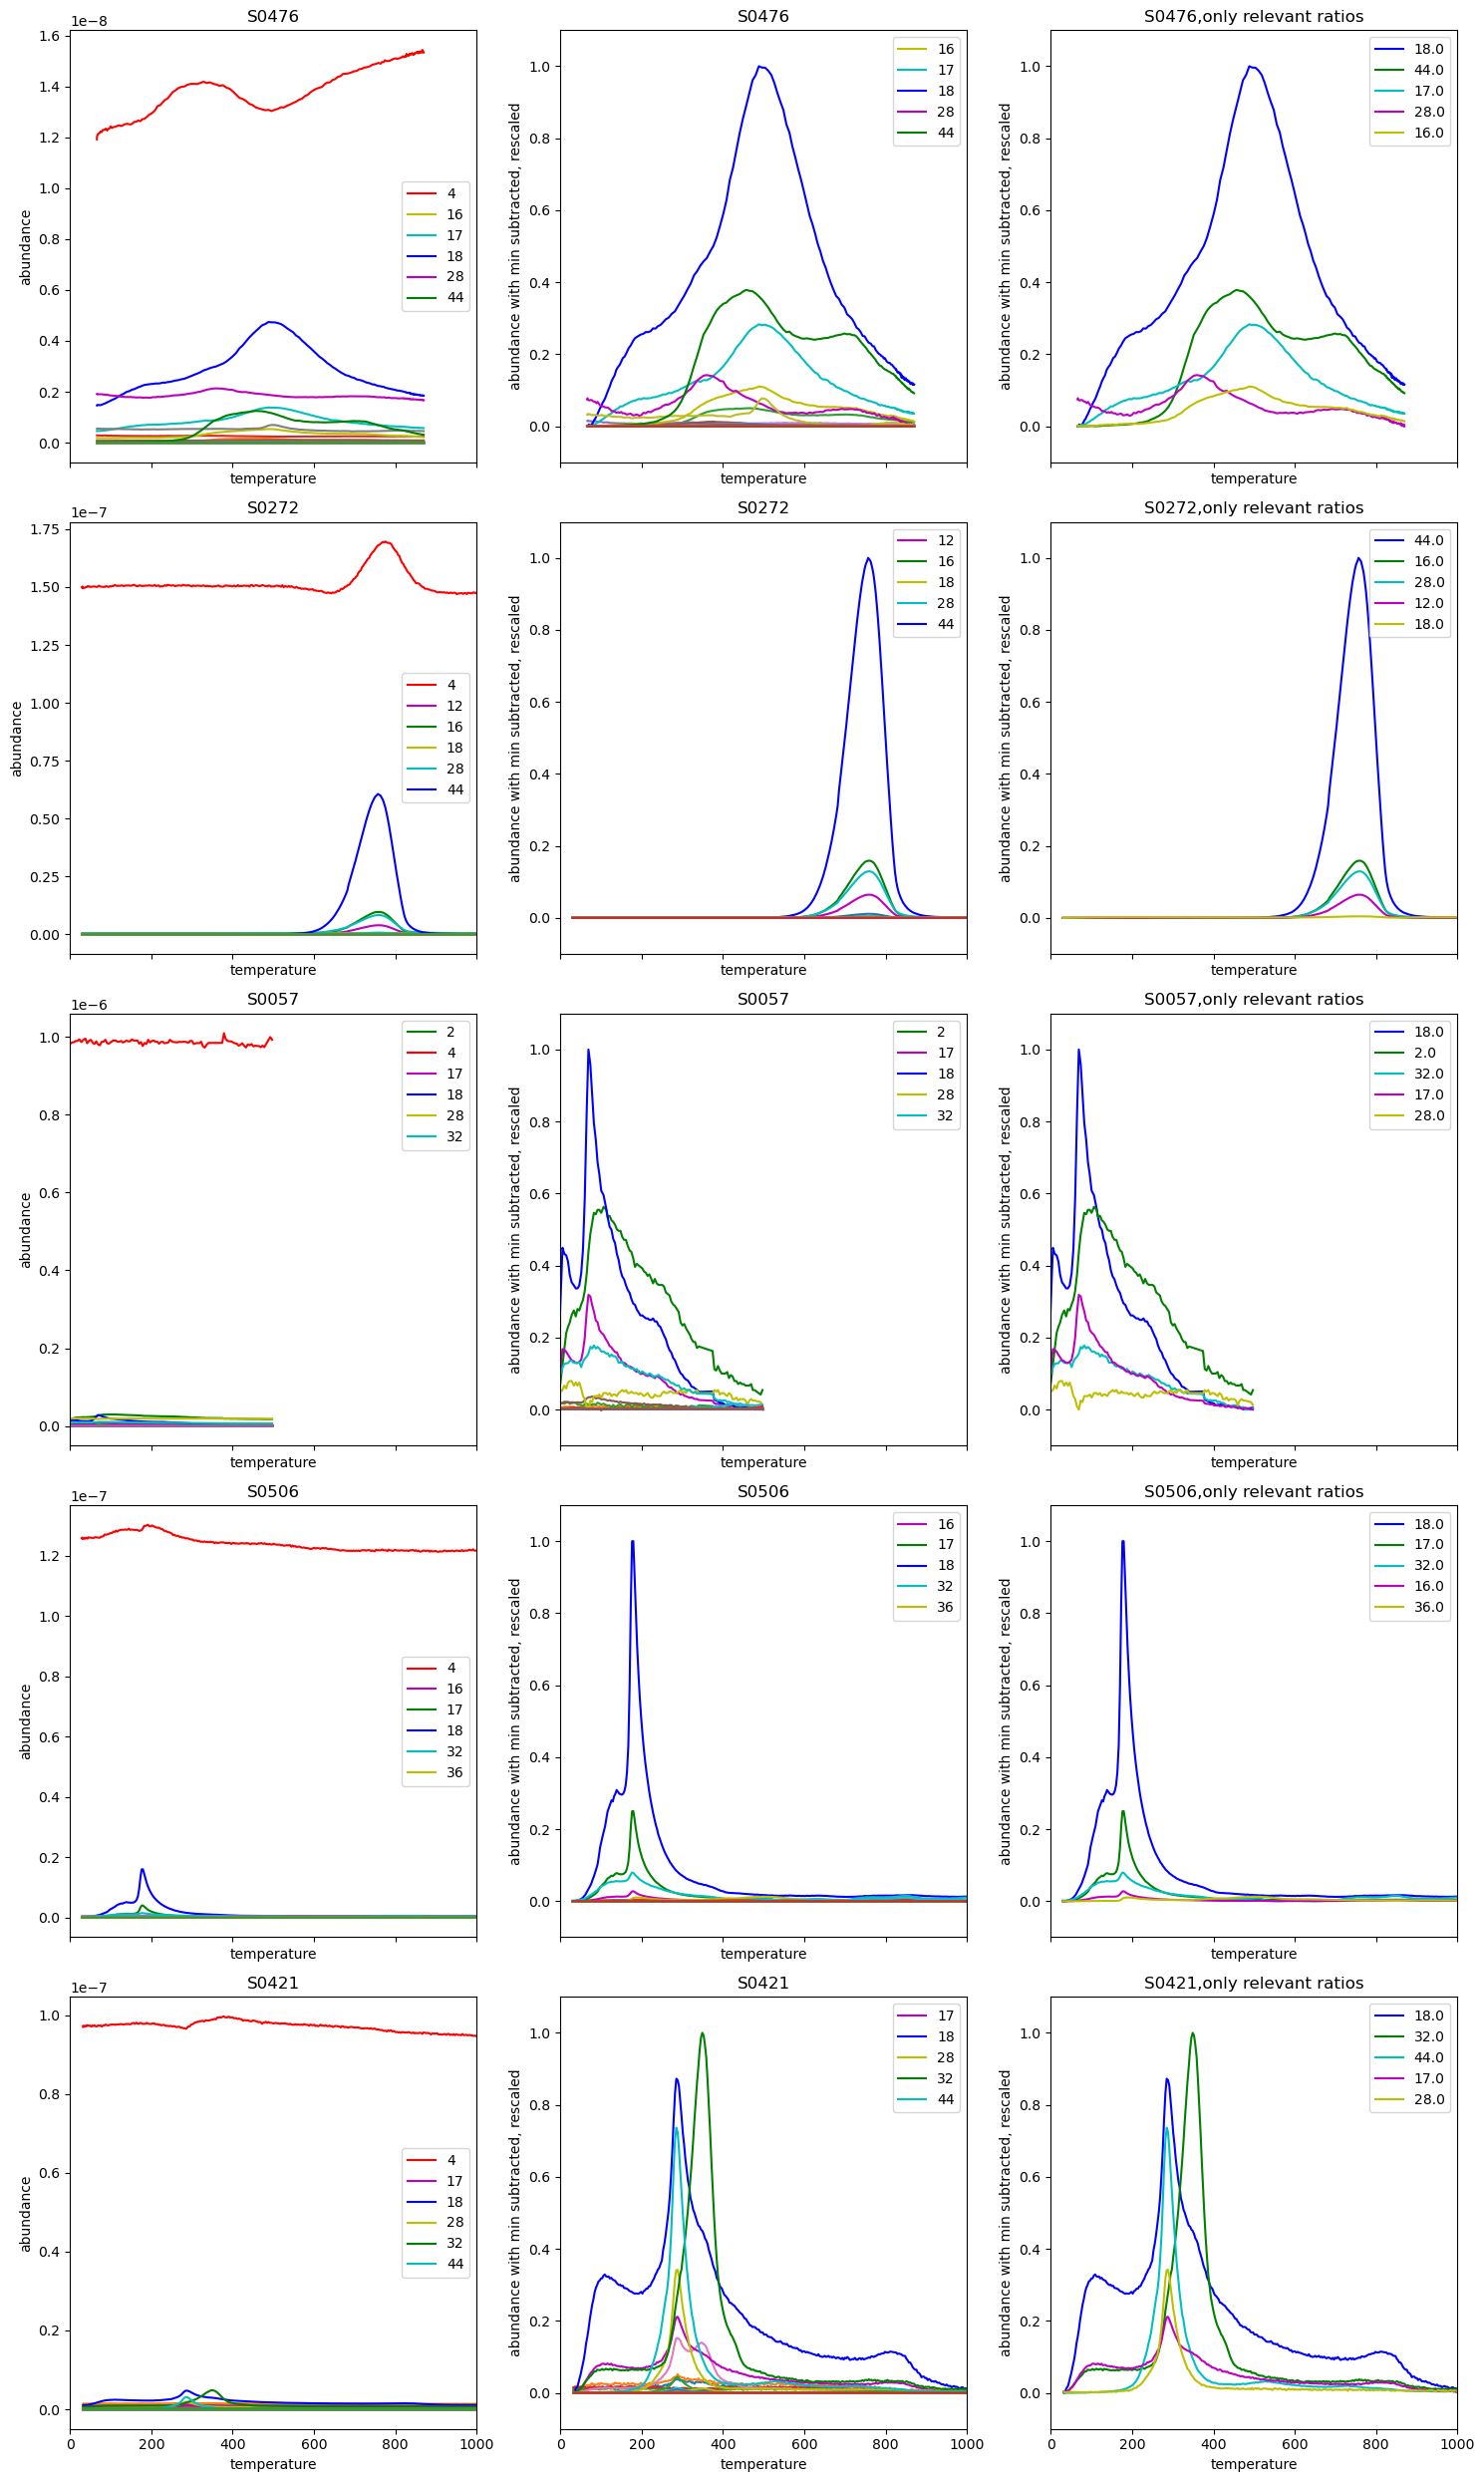

In [24]:
import warnings
warnings.filterwarnings("ignore") # ignore some annoying warnings

colors = ['b','g','c','m','y','r']



num_columns = 3

fig, ax = plt.subplots(num_samples,num_columns,sharex = True,figsize = (5*num_columns,5*num_samples))


for i, sample in enumerate(samples_list):

    # Load the dataframe

    df = pd.read_csv(train_files[sample])

    # Preprocess it

    df_mod = preprocess(df)

    relevant_ratios = find_relevant_ratios(df_mod)
    

    plt.subplot(num_samples,num_columns,num_columns*i+1)    

    for mz in range(0,99):
        X = df[df['m/z'] == mz].temp
        y = df[df['m/z'] == mz].abundance

        # We show a legend only for the first few values of mz in order to not clutter the picture
             
        if mz in np.append(relevant_ratios,[4]):
            plt.plot(X,y,label = str(mz),color = colors[int(np.where(np.append(relevant_ratios,[4])==mz)[0])])
        else:
            plt.plot(X,y,label = "")       
        

        plt.xlabel('temperature')
        plt.ylabel('abundance')
        plt.xlim(0,1000)
        plt.title(sample)

        plt.legend()

        
        
        # ax[i] = plt.show()
        plt.yscale('linear')
    
    plt.subplot(num_samples,num_columns,num_columns*i+2)    

    for mz in range(0,99):
        X = df_mod[df_mod['m/z'] == mz].temp
        y = df_mod[df_mod['m/z'] == mz].zero_one_rescale

        # We show a legend only for the first few values of mz in order to not clutter the picture
             
        if mz in relevant_ratios:
            plt.plot(X,y,label = str(mz),color = colors[int(np.where(relevant_ratios==mz)[0])])
        else:
            plt.plot(X,y,label = "")       
        

        plt.xlabel('temperature')
        plt.ylabel('abundance with min subtracted, rescaled')
        plt.xlim(0,1000)
        plt.ylim(-0.1,1.1)
        plt.title(sample)
        
        # ax[i] = plt.show()
    
        plt.legend()


    
        plt.yscale('linear')

    plt.subplot(num_samples,num_columns,num_columns*i+3)
    
    for mz in relevant_ratios:
        X = df_mod[df_mod['m/z'] == mz].temp
        y = df_mod[df_mod['m/z'] == mz].zero_one_rescale

        # We show all legends            
        
        plt.plot(X,y,label = str(mz),color = colors[int(np.where(relevant_ratios==mz)[0])])
        
        
        plt.xlabel('temperature')
        plt.ylabel('abundance with min subtracted, rescaled')
        plt.xlim(0,1000)
        plt.ylim(-0.1,1.1)
        plt.title(sample+",only relevant ratios")
        
        # ax[i] = plt.show()
    
        plt.legend()


    
        plt.yscale('linear')

    del df

    



fig.tight_layout()     
    
fig.show()




## Augmenting the train_labels file

We will add columns to it corresponding to the most prominent ratios, at what temperature they peak, what the peak is, and the sum of the average and the std_dev of the rescaled abundance

In [25]:
train_labels = pd.read_csv("../Data/train_labels.csv",index_col="sample_id")
train_labels

basalt  carbonate  chloride  iron_oxide  oxalate  oxychlorine  \
sample_id                                                                  
S0000           0          0         0           0        0            0   
S0001           0          1         0           0        0            0   
S0002           0          0         0           0        0            1   
S0003           0          1         0           1        0            0   
S0004           0          0         0           1        0            1   
...           ...        ...       ...         ...      ...          ...   
S0749           0          0         0           0        0            0   
S0750           0          0         0           0        0            0   
S0751           0          0         0           0        0            0   
S0752           0          0         0           1        0            0   
S0753           1          0         0           0        0            1   

           phyllosilicate  silicate  sulfate  sulfide  
sample_id                                              
S0000                   0         0        1        0  
S0001                   0         0        0        0  
S0002                   0         0        0        0  
S0003                   0         0        1        0  
S0004                   1         0        0        0  
...                   ...       ...      ...      ...  
S0749                   0         0        0        0  
S0750                   1         0        0        0  
S0751                   0         1        0        0  
S0752                   0         0        0        0  
S0753                   0         0        0        0  

[754 rows x 10 columns]

Add the relevant columns to it, also create a list with the labels so that we can easily access the columns corresponding to each ratio.

In [26]:
A = [] # the i-th element of this list will contain all features corresponding to the i-th ratio
Pa = [] # Each element of this list will contain peak abundance across ratios
Pt = [] # Each element of this list will contain peak abundance across ratios
PMS = [] # Each element of this list will contain peak mean+std across ratios

for i in range(num_of_ratios):
        
        train_labels[str(i+1)+'_ratio'] = np.nan
        train_labels[str(i+1)+'_ratio_peak_temp'] = np.nan
        train_labels[str(i+1)+'_ratio_peak_abund'] = np.nan
        train_labels[str(i+1)+'_ratio_meanstd_abund'] = np.nan

        A.append([str(i+1)+'_ratio',str(i+1)+'_ratio_peak_temp',str(i+1)+'_ratio_peak_abund',str(i+1)+'_ratio_meanstd_abund'])
        Pt.append(str(i+1)+'_ratio_peak_temp')
        Pa.append(str(i+1)+'_ratio_peak_abund')
        PMS.append(str(i+1)+'_ratio_meanstd_abund')

train_labels


basalt  carbonate  chloride  iron_oxide  oxalate  oxychlorine  \
sample_id                                                                  
S0000           0          0         0           0        0            0   
S0001           0          1         0           0        0            0   
S0002           0          0         0           0        0            1   
S0003           0          1         0           1        0            0   
S0004           0          0         0           1        0            1   
...           ...        ...       ...         ...      ...          ...   
S0749           0          0         0           0        0            0   
S0750           0          0         0           0        0            0   
S0751           0          0         0           0        0            0   
S0752           0          0         0           1        0            0   
S0753           1          0         0           0        0            1   

           phyllosilicate  silicate  sulfate  sulfide  ...  \
sample_id                                              ...   
S0000                   0         0        1        0  ...   
S0001                   0         0        0        0  ...   
S0002                   0         0        0        0  ...   
S0003                   0         0        1        0  ...   
S0004                   1         0        0        0  ...   
...                   ...       ...      ...      ...  ...   
S0749                   0         0        0        0  ...   
S0750                   1         0        0        0  ...   
S0751                   0         1        0        0  ...   
S0752                   0         0        0        0  ...   
S0753                   0         0        0        0  ...   

           3_ratio_peak_abund  3_ratio_meanstd_abund  4_ratio  \
sample_id                                                       
S0000                     NaN                    NaN      NaN   
S0001                     NaN                    NaN      NaN   
S0002                     NaN                    NaN      NaN   
S0003                     NaN                    NaN      NaN   
S0004                     NaN                    NaN      NaN   
...                       ...                    ...      ...   
S0749                     NaN                    NaN      NaN   
S0750                     NaN                    NaN      NaN   
S0751                     NaN                    NaN      NaN   
S0752                     NaN                    NaN      NaN   
S0753                     NaN                    NaN      NaN   

           4_ratio_peak_temp  4_ratio_peak_abund  4_ratio_meanstd_abund  \
sample_id                                                                 
S0000                    NaN                 NaN                    NaN   
S0001                    NaN                 NaN                    NaN   
S0002                    NaN                 NaN                    NaN   
S0003                    NaN                 NaN                    NaN   
S0004                    NaN                 NaN                    NaN   
...                      ...                 ...                    ...   
S0749                    NaN                 NaN                    NaN   
S0750                    NaN                 NaN                    NaN   
S0751                    NaN                 NaN                    NaN   
S0752                    NaN                 NaN                    NaN   
S0753                    NaN                 NaN                    NaN   

           5_ratio  5_ratio_peak_temp  5_ratio_peak_abund  \
sample_id                                                   
S0000          NaN                NaN                 NaN   
S0001          NaN                NaN                 NaN   
S0002          NaN                NaN                 NaN   
S0003          NaN                NaN                 NaN   
S0004          NaN         

Populate the columns

In [27]:

for index, sample in enumerate(train_labels.index): # index corresponds to the index-th sample
    
    df = pd.read_csv(train_files[sample])

    df_mod = preprocess(df)

    relevant_ratios = find_relevant_ratios(df_mod) # this is a list with the most prominent ratios, sorted by prominence

    

    for i in range(len(relevant_ratios)): # i corresponds to the i+1-th most prominent ratio

        label = str(i+1)+'_ratio'

        train_labels[label][index] = relevant_ratios[i]

        

        index_where_max_ab_occurs = df_mod[df_mod['m/z']==relevant_ratios[i]].zero_one_rescale.argmax()
        # this is the pandas version of argmax and returns a scalar, whereas the numpy version returns an array, apparently

        train_labels[label+'_peak_temp'][index] = df_mod[df_mod['m/z']==relevant_ratios[i]].temp.iloc[index_where_max_ab_occurs]

        train_labels[label+'_peak_abund'][index] = df_mod[df_mod['m/z']==relevant_ratios[i]].zero_one_rescale.max()

        train_labels[label+'_meanstd_abund'][index] = df_mod[df_mod['m/z']==relevant_ratios[i]].zero_one_rescale.mean()+df_mod[df_mod['m/z']==relevant_ratios[i]].zero_one_rescale.std()




    del df
    del df_mod
        




train_labels.head() 

basalt  carbonate  chloride  iron_oxide  oxalate  oxychlorine  \
sample_id                                                                  
S0000           0          0         0           0        0            0   
S0001           0          1         0           0        0            0   
S0002           0          0         0           0        0            1   
S0003           0          1         0           1        0            0   
S0004           0          0         0           1        0            1   

           phyllosilicate  silicate  sulfate  sulfide  ...  \
sample_id                                              ...   
S0000                   0         0        1        0  ...   
S0001                   0         0        0        0  ...   
S0002                   0         0        0        0  ...   
S0003                   0         0        1        0  ...   
S0004                   1         0        0        0  ...   

           3_ratio_peak_abund  3_ratio_meanstd_abund  4_ratio  \
sample_id                                                       
S0000                0.024563               0.009736     28.0   
S0001                0.033209               0.024006     16.0   
S0002                0.294738               0.075850     16.0   
S0003                0.260027               0.061956     28.0   
S0004                0.238290               0.082294     16.0   

           4_ratio_peak_temp  4_ratio_peak_abund  4_ratio_meanstd_abund  \
sample_id                                                                 
S0000                 35.420            0.010877               0.009101   
S0001                497.404            0.093082               0.020585   
S0002                545.304            0.040446               0.013012   
S0003                593.222            0.081701               0.031606   
S0004                471.733            0.084732               0.026218   

           5_ratio  5_ratio_peak_temp  5_ratio_peak_abund  \
sample_id                                                   
S0000         19.0            105.458            0.006600   
S0001         18.0            -60.370            0.030234   
S0002          1.0            145.673            0.004003   
S0003         16.0            593.222            0.083077   
S0004         44.0            333.273            0.029998   

           5_ratio_meanstd_abund  
sample_id                         
S0000                   0.002841  
S0001                   0.019214  
S0002                   0.001801  
S0003                   0.028375  
S0004                   0.013378  

[5 rows x 30 columns]

Example of how the label thing works:

In [28]:
train_labels[A[1]].head()

2_ratio  2_ratio_peak_temp  2_ratio_peak_abund  \
sample_id                                                   
S0000         17.0            103.666            0.276675   
S0001          2.0            -60.370            0.061658   
S0002         17.0            145.673            0.254002   
S0003         44.0            593.222            0.485557   
S0004         32.0            471.733            0.595652   

           2_ratio_meanstd_abund  
sample_id                         
S0000                   0.105220  
S0001                   0.028689  
S0002                   0.087770  
S0003                   0.147348  
S0004                   0.164283

In [29]:
train_labels[Pt].head()

1_ratio_peak_temp  2_ratio_peak_temp  3_ratio_peak_temp  \
sample_id                                                            
S0000                103.666            103.666            103.666   
S0001                497.404            -60.370            -60.370   
S0002                145.673            145.673            545.304   
S0003                120.720            593.222            120.720   
S0004                142.874            471.733            142.874   

           4_ratio_peak_temp  5_ratio_peak_temp  
sample_id                                        
S0000                 35.420            105.458  
S0001                497.404            -60.370  
S0002                545.304            145.673  
S0003                593.222            593.222  
S0004                471.733            333.273

In [30]:
train_labels[Pa].head()

1_ratio_peak_abund  2_ratio_peak_abund  3_ratio_peak_abund  \
sample_id                                                               
S0000                     1.0            0.276675            0.024563   
S0001                     1.0            0.061658            0.033209   
S0002                     1.0            0.254002            0.294738   
S0003                     1.0            0.485557            0.260027   
S0004                     1.0            0.595652            0.238290   

           4_ratio_peak_abund  5_ratio_peak_abund  
sample_id                                          
S0000                0.010877            0.006600  
S0001                0.093082            0.030234  
S0002                0.040446            0.004003  
S0003                0.081701            0.083077  
S0004                0.084732            0.029998

Since the ratios are ordered by prominence, the column 1_ratio_meanstd_abund should always have the largest value compared to i_ratio_meanstd_abund

In [31]:
train_labels[PMS].sample(3)

1_ratio_meanstd_abund  2_ratio_meanstd_abund  \
sample_id                                                 
S0743                   0.626309               0.161535   
S0622                   0.428576               0.100012   
S0061                   0.196361               0.106467   

           3_ratio_meanstd_abund  4_ratio_meanstd_abund  5_ratio_meanstd_abund  
sample_id                                                                       
S0743                   0.115033               0.046173               0.032748  
S0622                   0.056910               0.016535               0.012740  
S0061                   0.028385               0.025663               0.013301

In [32]:
train_labels.to_csv("../Data/train_labels_augmented.csv")